# Data preparation

In [5]:
import pandas as pd
from dotenv import load_dotenv
import os

import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
from utils import plot_recessions

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

load_dotenv();

## United States

Data:
- PIB: Gross Domestic Product, Quarterly, Billions of Dollars [GDP](https://fred.stlouisfed.org/series/GDP).
- M3: [ShadowStats](http://www.shadowstats.com).
- Consumer Price Index for All Urban Consumers: All Items in U.S. City Average. Seasonally adjusted: [FRED CPIAUCSL](CPIAUCSL).


In [6]:
from fredapi import Fred

fred = Fred(api_key=os.environ.get('FRED_API_KEY'))

In [7]:
df_us = pd.DataFrame()
s_m3 = pd.read_csv('data/m3-us.csv', sep=';', parse_dates=['Date'], index_col='Date') # Monthly data, USD billions
s_gdp = fred.get_series('GDP').rename('gdp') # Quarterly data
s_cpi = fred.get_series('CPIAUCSL').rename('cpi') # Monthly data

df_us = pd.concat([s_m3, s_gdp, s_cpi], axis=1)
df_us['v'] = df_us['gdp']/df_us['m3']

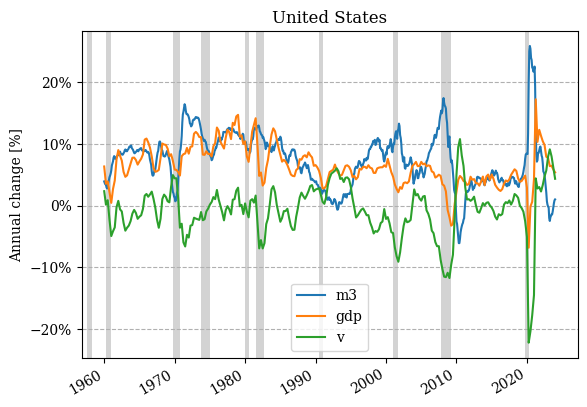

In [8]:
def plot_pct_change(df, region):
  fig, ax = plt.subplots()

  df[['m3']].pct_change(periods=12, fill_method=None).plot(ax=ax)
  df[['gdp', 'v']].dropna().pct_change(periods=4, fill_method=None).plot(ax=ax)
  plot_recessions(ax)

  ax.set_title(region)
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
  ax.grid(which='major', axis='y', linestyle='--')  #  or both
  ax.set_xlabel('')
  ax.set_ylabel('Annual change [%]');

plot_pct_change(df_us, 'United States')

## Euro area

Data: 
- GDP: two options:
    - Gross domestic product at market prices, Euro area 20 (fixed composition) as of 1 January 2023, Quarterly. [ECB](https://data.ecb.europa.eu/data/datasets/MNA/MNA.Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.LR.N)
    - **Gross domestic product at market prices, Euro area (Member States and Institutions of the Euro Area) changing composition, Quarterly.** [ECB](https://data.ecb.europa.eu/data/datasets/MNA/MNA.Q.N.U2.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.V.N)
- M3: Monetary aggregate M3 reported by MFIs, central gov. and post office giro institutions in the euro area (stocks), Euro area (changing composition), Monthly. [ECB](https://data.ecb.europa.eu/data/datasets/BSI/BSI.M.U2.N.V.M30.X.1.U2.2300.Z01.E).
- HICP: HICP - Overall index, Euro area (changing composition), Monthly. [ECB](https://data.ecb.europa.eu/data/datasets/ICP/ICP.M.U2.N.000000.4.INX).

/Users/miguel/Documents/workspace/money-growth/utils.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(io.StringIO(response.text), parse_dates=[


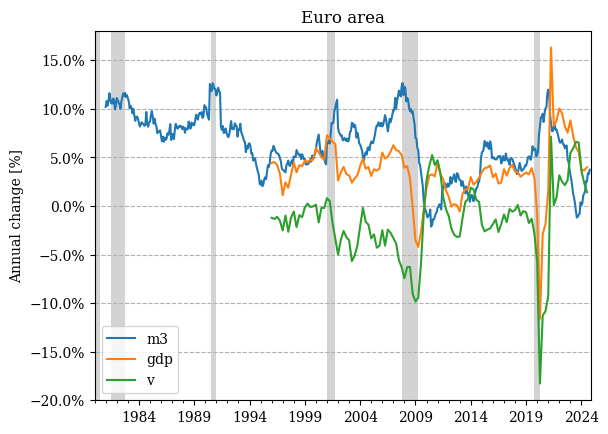

In [9]:
from utils import get_ecb_data

s_m3 = get_ecb_data('BSI',
                     'M.U2.N.V.M30.X.1.U2.2300.Z01.E').rename('m3') # Monthly data
s_gdp = get_ecb_data('MNA',
                      'Q.N.U2.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.V.N').rename('gdp') # Quarterly data
s_cpi = get_ecb_data('ICP',
                     'M.U2.N.000000.4.INX').rename('cpi') # Monthly data

df_eu = pd.concat([s_m3, s_gdp, s_cpi], axis=1)
df_eu['v'] = df_eu['gdp']/df_eu['m3']

plot_pct_change(df_eu, 'Euro area')

## Switzerland

- Inflation according to the national consumer price index: both series are the same when percentage change is computed.
    - `plkopr{LD2010100}`: National index (Dec. 2020=100) [SNB](https://data.snb.ch/en/topics/uvo/cube/plkopr).
    - `plkoprinfla{TLK}`: Change [SNB](https://data.snb.ch/en/topics/uvo/cube/plkoprinfla).

Other options for inflation: 
- Eurostat HICP - monthly data (index). [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/prc_hicp_midx/default/table?lang=en&category=prc.prc_hicp).
- IMF PCPIP: Inflation rate, averge consumer prices. [IMF](https://data.imf.org/?sk=4ffb52b2-3653-409a-b471-d47b46d904b5)

/Users/miguel/Documents/workspace/money-growth/utils.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url,


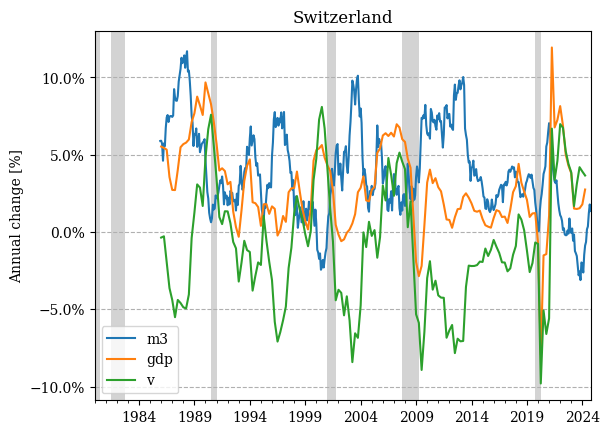

In [10]:
from utils import get_snb_data

table_id = "snbmonagg"
params = {'dimSel': 'D0(B),D1(GM3)',
          'fromDate': '1980-01',
          }

s_m3 = get_snb_data(table_id, params)['Value'].rename('m3') # Monthly data

table_id = "gdpap"
params = {'dimSel': 'D0(WMF),D1(BBIPS)',
          'fromDate': '1980-01',
          }
s_gdp = get_snb_data(table_id, params)['Value'].rename('gdp') # Quarterly data

table_id = 'plkopr'
params = {'dimSel': 'D0(LD2010100)',
          'fromDate': '1980-01',
          }
s_cpi = get_snb_data(table_id, params)['Value'].rename('cpi') # Monthly data

df_ch = pd.concat([s_m3, s_gdp, s_cpi], axis=1)
df_ch['v'] = df_ch['gdp']/df_ch['m3']

plot_pct_change(df_ch, 'Switzerland')

## United Kingdom

- M4x: LPMAUYN, Monthly amounts outstanding of M4 (monetary financial institutions' sterling M4 liabilities to private sector) (in sterling millions) seasonally adjusted [BoE](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=NIxAZxI1x&FromCategoryList=Yes&NewMeaningId=LM4,LM4L&CategId=6&HighlightCatValueDisplay=M4).
- Gross Domestic Product at market prices: Current price: Seasonally adjusted £m, quarterly [ONS](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ybha/pn2).
- Inflation: CPI INDEX 00: ALL ITEMS 2015=100 [ONS](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7bt/mm23).

/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_37183/2910342612.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s_gdp = pd.read_csv('data/gdp-gb.csv', skiprows=84, names=["Date", "Value"], parse_dates=['Date'], index_col='Date')['Value'].rename('gdp')
/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_37183/2910342612.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s_cpi = pd.read_csv('data/cpi-gb.csv', skiprows=190, names=["Date", "Value"], parse_dates=['Date'], index_col='Date')['Value'].rename('cpi')


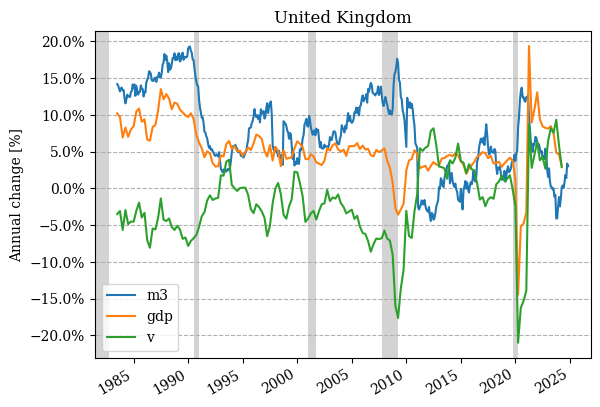

In [11]:
from utils import get_boe_data

s_m3 = get_boe_data('LPMAUYN').rename('m3')
s_gdp = pd.read_csv('data/gdp-gb.csv', skiprows=84, names=["Date", "Value"], parse_dates=['Date'], index_col='Date')['Value'].rename('gdp')
s_cpi = pd.read_csv('data/cpi-gb.csv', skiprows=190, names=["Date", "Value"], parse_dates=['Date'], index_col='Date')['Value'].rename('cpi')

df_uk = pd.concat([s_m3, s_gdp, s_cpi], axis=1)
df_uk['v'] = df_uk['gdp']/df_uk['m3']

plot_pct_change(df_uk, 'United Kingdom')

## Japan

Data:
- M3: MD02'MAM1NAM3M3MO: M3/Average Amounts Outstanding/Money Stock [BoJ Time-Series Data Search](https://www.stat-search.boj.or.jp/ssi/mtshtml/md02_m_1_en.html).
- CPI: 
    - e-Stat: [2020-Base Consumer Price Index. Monthly Report. 2024Jul.](https://www.e-stat.go.jp/en/stat-search/files?page=1&layout=datalist&toukei=00200573&tstat=000001150147&cycle=1&year=20240&month=23070907&tclass1=000001150149&result_back=1&tclass2val=0)
    - Bank of Japan: [Measures of Underlying Inflation](https://www.boj.or.jp/en/research/research_data/cpi/index.htm).

Monetary aggregates reference: [Monetary Aggregates (market volume, outstanding)](https://www.boj.or.jp/en/statistics/outline/note/notest31.htm).

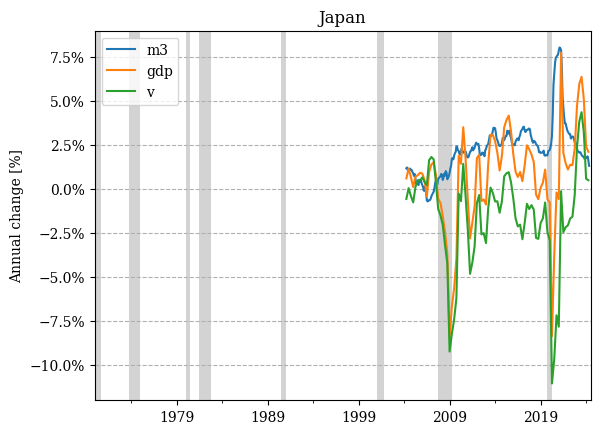

In [12]:
from utils import get_boe_data

s_m3 = pd.read_csv('data/m3-jp.csv',
                          skiprows=3,
                          names=['Date', 'Value'],
                          parse_dates=['Date'],
                          date_format={'Date': '%Y/%m'},
                          index_col='Date')['Value'].rename('m3') # Monthly data
s_gdp = fred.get_series('JPNNGDP').rename('gdp') # Quarterly data
s_cpi = pd.read_csv('data/jp-cpi-e-stat.csv',
                           parse_dates=['Date'],
                           index_col='Date')[r'CPI (2020=100)'].rename('cpi') # Monthly data

df_jp = pd.concat([s_m3, s_gdp, s_cpi], axis=1)
df_jp['v'] = df_jp['gdp']/df_jp['m3']

plot_pct_change(df_jp, 'Japan')

## Monetary aggregates in the U.S.

/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_37183/2997737583.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_us['m3'].pct_change(periods=12).plot(ax=ax, label='M3')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


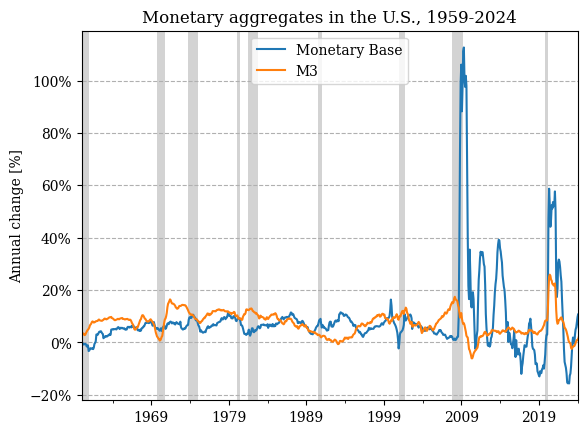

In [13]:
fig, ax = plt.subplots()


m0 = fred.get_series('BOGMBASE') 
m0.pct_change(periods=12).plot(ax=ax, label='Monetary Base')
df_us['m3'].pct_change(periods=12).plot(ax=ax, label='M3')
# (df_us['m3']/m0*1e3).plot(ax=ax, secondary_y=True, label='multiplicador')
plot_recessions(ax)

ax.set_title('Monetary aggregates in the U.S., 1959-2024')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or bothdd
ax.set_xlabel('')
ax.set_ylabel('Annual change [%]')
ax.legend();
ax.set_xlim(['1960', '2024'])

fig.savefig(f'figures/broad-vs-narrow-money.eps', bbox_inches='tight')
fig.savefig(f'figures/broad-vs-narrow-money.svg', bbox_inches='tight')

## Data export

In [11]:
df_us.to_pickle('data/us.pickle')
df_eu.to_pickle('data/eu.pickle')
df_ch.to_pickle('data/ch.pickle')
df_uk.to_pickle('data/uk.pickle')
df_jp.to_pickle('data/jp.pickle')